<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b>

* It is expected for user to be familiar with Python. 
* It is expected, that **MLST-ASv2** product data is downloaded from [LSA-SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MLST-ASv2/NETCDF/2022/) in `NetCDF4` format for July and August 2022 and saved locally.

</div>

<hr>

# Comparison Between LSA-SAF MLST-ASv2 and Air Temperature Measurements

#### About 


LSA-SAF Land Surface Temperature - All Sky Version 2 product ([MLST-ASv2](https://lsa-saf.eumetsat.int/en/data/products/land-surface-temperature-and-emissivity/)) is an estimate for the temperature of the ground surface produced using data from the MSG satellite. In meteorology, the measurement of air temperature at 2 m height in a [Stevenson screen](https://en.wikipedia.org/wiki/Stevenson_screen) (an instrument shelter) is traditionally used.

Land surface temperature (LST) is related to the air temperature (at 2 m), but the exact relationship is rather complicated. In this notebook, we try to illustrate this relation, rather than precisely investigate it. We decided to use the LSA SAF MLST-ASv2 product instead of the LSA SAF Land Surface Temperature product (MLST) since LSA SAF MLST-ASv2 estimates LST even in cloudy conditions.

Air temperature is measured at a limited number of in-situ meteorological stations. On the contrary, the satellite measurements conducted by the Meteosat Second Generation satellite (MSG) provide gridded data on a full disk.

The area covered by a single pixel typically does not have uniform temperature as the temperature is greatly affected by land cover, altitude, etc. Examples of heterogeneous pixels can be urbanized areas and geographically diverse areas (mountains, hills, different types of vegetation, etc.).

Knowing the exact relationship between air temperature and satellite based LST would have numerous useful applications. There are several methodologies to find the relationship between air temperature and LST. For example, there is both a seasonal dependency ([Noserikia et all, 2023](https://doi.org/10.1016/j.scitotenv.2023.167306)) and a major land cover dependency ([do Nascimento et all, 2022](https://doi.org/10.3390/atmos13030491)).

In this notebook, we aim to demonstrate the differences between LST from MLST-ASv2, and air temperature measured at 2 m height in Stevenson screen.

#### How to Access the Data

For this example, MLST-ASv2 measurements from July 1, 2022, to August 31, 2022, are used. All measurements are available as `NetCDF4` as well as `HDF5` files, but only the former will be used here. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration.
Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program.

Measurements of the air temperature are attached to this notebook in `.csv` format. They are publicly available on the Slovenian Environmental Agency (ARSO) [data archive](http://www.meteo.si/met/sl/archive/). The data access is described in video tutorials [1](https://www.youtube.com/watch?v=RCV4mdjevS0), [2](https://www.youtube.com/watch?v=MzSnSy34Dbw) and [3](https://www.youtube.com/watch?v=CPcSwqnTu2w).

#### Basic Facts on the LSA SAF MLST-ASv2 

 > **Spatial resolution**: 3km at nadir 
 >
 > **Spatial coverage**: MSG disk 
 >
 > **Time steps**: 30 min  
 >
 > **Data availability**: from 2004

#### Module Outline:
* [1 - Preparing the Data](#First)
* [2 - Plotting the Measurements](#Second)
* [3 - Comparison](#Third)
* [4 - Conclusion](#Fourth)

#### Load Required Libraries

In [1]:
import matplotlib.pyplot as plt     # a library tht provides plotting capability
import datetime as dt               # a library that allows us to work with dates and times
import xarray as xr                 # a library that helps us work efficiently with multidimensional arrays with
import numpy as np                  # a library that lets us work with arrays
import pandas as pd                 # a library for time series analysis

# Set the matplotlib backend to inline
%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = [13, 8]

### <a id='First'></a>1. Preparing the Data

Air temperature was measured by the Slovenian Environmental Agency (ARSO) in the summer of 2022. The data was obtained from the automated meteorological weather station in Ljubljana, located at 46.0655° N, 14.5124° E at an elevation of 299 m. Measurements are recorded every 10 min.

The in-situ meteorological station in Ljubljana is located within an urbanized area on an open grass-covered area with dimensions 50 m x 50 m and is surrounded by urbanized areas.

The air temperature measurements are imported from a `.csv` file `AIR_2.00m.csv` with columns `time` and `temperature`. Measurements are imported as `pandas.DataSet` and `pd.to_datetime()` is used to change time entry from `string` to `DateTime` object.

In [2]:
# Load air temperature measurements
air_2=pd.read_csv("AIR_2.00m.csv",sep=",")

# Change time from str to datetime
air_2["time"]=pd.to_datetime(air_2["time"], errors="coerce")

# Show the dataset
print(air_2)

                    time  temperature
0    2022-06-30 22:50:00         23.6
1    2022-06-30 23:00:00         23.4
2    2022-06-30 23:10:00         23.2
3    2022-06-30 23:20:00         22.8
4    2022-06-30 23:30:00         22.6
...                  ...          ...
8925 2022-08-31 22:20:00         17.0
8926 2022-08-31 22:30:00         16.9
8927 2022-08-31 22:40:00         16.9
8928 2022-08-31 22:50:00         16.8
8929 2022-08-31 23:00:00         16.8

[8930 rows x 2 columns]


Before loading the MLST-ASv2 data we need to define the dates and area of interest. In this case, we are extracting only a single pixel, the center from which is the closest to the meteorological station in Ljubljana.

In [3]:
# Start and end dates are defined
start_date=dt.datetime(2022, 8, 1)
end_date=dt.datetime(2022, 8, 7)

# List of DateTime objects for measurements is defined
date_range=pd.date_range(start_date,end_date-dt.timedelta(minutes=30),freq='30T')

# Location is defined
Ljubljana_lat=46.0655
Ljubljana_lon=14.5124

In the next step, we will extract only values of the pixel, that is nearest to the location of the interest, by using `method="nearest"`, since the location might not be perfectly aligned with a pixel center. Since there might be missing data only the valid `datetime` objects will be appended to the list of dates.

We then load the data from the NetCDF4 files. The slow load is used when the `xarray` dataset is first defined and only the values matching pre-defined coordinates are actually loaded into memory.

In [4]:
# Create an empty list
LSA_SAF_temperature=np.empty(0)
LSA_SAF_date=[]

# Loop over the dates of interest
for i, time in enumerate(date_range):        
        try:
                # Define dataset
                LSA_SAF_ds=xr.open_dataset("Data/NETCDF4_LSASAF_MSG_MLST-ASv2_MSG-Disk_"
                                        +str("{:02d}".format(date_range[i].year))
                                        +str("{:02d}".format(date_range[i].month))
                                        +str("{:02d}".format(date_range[i].day))
                                        +str("{:02d}".format(date_range[i].hour))
                                        +str("{:02d}".format(date_range[i].minute))
                                        +".nc")
               
                # Load and append the desired data point
                LSA_SAF_temperature=np.append(
                                        LSA_SAF_temperature,
                                        LSA_SAF_ds.sel(lat=[Ljubljana_lat], lon=[Ljubljana_lon], method="nearest")['MLST-AS'].load().values[0]
                                         )     
                # Append the measurement time
                LSA_SAF_date.append(date_range[i])

                # Close dataset to free the memory
                LSA_SAF_ds.close()

        # In case loading was not successful
        except:
                print("Missing value: "+str(date_range[i]))

### <a id='Second'></a>2. Plotting the Measurements

In this step, we will plot all the measurements using. We can limit the range on the x-axis using the `xlim` to plot only the measurements for a certain time period, in this case, one week.

Text(0.5, 1.0, 'LSA SAF MLST-ASv2 vs Air temperature \n Location: Ljubljana Bežigrad')

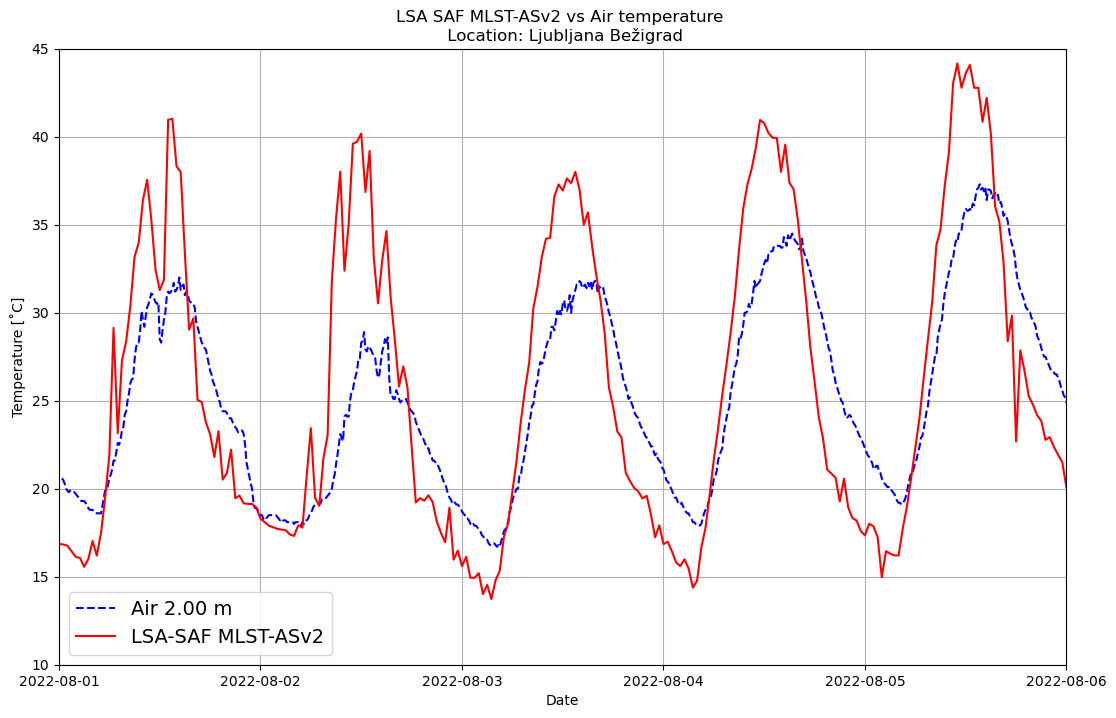

In [5]:
# Font and figure sizes are defined
fontsize=14
fig=plt.figure()

# The air temperature measurements are plotted
plt.plot(air_2["time"].to_numpy(),
         air_2["temperature"].to_numpy(),
         label="Air 2.00 m",
         color="blue",
         linestyle='dashed')


# LSA-SAF MLST-ASv2 measurements are plotted
plt.plot(LSA_SAF_date,
         LSA_SAF_temperature,
         label="LSA-SAF MLST-ASv2",
         color="red"
         )

# Set plot limits
plt.xlim(pd.Timestamp('2022-08-01'), pd.Timestamp('2022-08-06'))
plt.ylim(10,45)

#Set grid and ticks
plt.grid()
plt.xlabel('Date')
plt.ylabel('Temperature [˚C]')

# Add legend
plt.legend(fontsize=fontsize)

plt.title('LSA SAF MLST-ASv2 vs Air temperature \n Location: Ljubljana Bežigrad')

# Figure can be saved with (uncoment)
#plt.savefig("img/LSA_SAF_MLST-ASv2_comparison.png")

### <a id='Third'></a>3. Comparison

From the figure, we are able to observe that LST and air temperature are correlated although there might be some phase shifts. Air temperature is shifted slightly in time behind LST and at the same time exhibits a smaller amplitude than LSA SAF LST.

### <a id='Fourth'></a>4. Conclusion

With this notebook, we demonstrate the differences among LST from MLST-ASv2 and air temperature at 2 m. Loading and exploration of MLST-ASv2 and in-situ measurements is accomplished with Python. Presented are time series of temperature from different sources.

#### References:

* Nadbath M. (2008). Meteorološka postaja Ljubljana Bežigrad, Naše Okolje, special edition. [https://meteo.arso.gov.si/uploads/probase/www/climate/text/sl/stations/ljubljana-bezigrad.pdf](https://meteo.arso.gov.si/uploads/probase/www/climate/text/sl/stations/ljubljana-bezigrad.pdf). Accessed: 19.12.2023.    

* do Nascimento A.C.L., Galvani, E., Gobo, J.P.A., et all. (2022) Comparison between Air Temperature and Land Surface Temperature for the City of São Paulo, Brazil. Atmosphere. [https://doi.org/10.3390/atmos13030491](https://doi.org/10.3390/atmos13030491). Accessed: 19.12.2023.

* Naserikia M., Hart M., Nazarian N., et all. (2023) Land surface and air temperature dynamics: The role of urban form and seasonality. Sci. of the Tot. Environment. [https://doi.org/10.1016/j.scitotenv.2023.167306](https://doi.org/10.1016/j.scitotenv.2023.167306) Accessed: 19.12.2023.